# Load Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

filename = 'SyntheticImages'
zip_path = '/content/drive/MyDrive/' + filename + '.zip'
dir = '/content/drive/MyDrive/' + filename

Mounted at /content/drive


# Extract zip file

In [ ]:
import zipfile
import os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(dir)


## Extract Features from File Name:

In [18]:
import numpy as np
from datetime import datetime

# Function to extract date, satellite position and rotation from filename
def extract_data_from_filename(filename):
  # Extract the relevant parts of the filename
  name_parts = filename.split('_')

  date_str = name_parts[1]
  sat_pos = np.array(list(map(float,name_parts[2].split(','))))
  sat_rot = np.array(list(map(float,name_parts[3].replace('.jpg','').split(','))))

  # Convert date to a more usable format (e.g., timestamp or separate features)
  date_time = datetime.strptime(date_str, "%d-%m-%Y %H:%M:%S.%f")
  timestamp = date_time.timestamp()  # This gives you a float representing the time

  return timestamp, sat_pos, sat_rot

#filename = "cubesat_18-09-2024 21/21/57.240476_5878.28625250211,-1010.25371810028,3148.8815068145_0.9887074,-0.117828,-0.04034194,0.08334854.jpg"
#print(extract_data_from_filename(filename))

## Data Preprocessing

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_image(image_path):
  img = load_img(image_path, target_size=(102, 102))
  img = img_to_array(img) / 255.0  # Normalize pixel values
  return img

## Normalization Layer for Quaternion:

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class QuaternionNormalization(Layer):
    def call(self, inputs):
        # Normalize the quaternion to ensure the output has unit length
        return tf.nn.l2_normalize(inputs, axis=-1)


# convolutional neural network (CNN)

## Model Architecture:

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Layer
from tensorflow.keras.models import Model

# CNN for image processing
image_input = Input(shape=(102, 102, 3))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Date and satellite position as additional inputs
numerical_input = Input(shape=(1 + 3,))  # 1 for timestamp (or 1 for timestamp and additional features) + 3 for sat position

# Combine image features and numerical inputs
combined = Concatenate()([x, numerical_input])

# Fully connected layers
y = Dense(128, activation='relu')(combined)
y = Dense(64, activation='relu')(y)

# Output layer for satellite rotation prediction (4 values)
output = Dense(4, activation='linear')(y)

# Normalize quaternion output to ensure it has unit length
quaternion_output = QuaternionNormalization()(output)

# Define model
model = Model(inputs=[image_input, numerical_input], outputs=quaternion_output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 102, 102,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 100, 100,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 50, 50,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 24, 24,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 36864)     │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 36868)     │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │  4,719,232 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 4)         │        260 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quaternion_normali… │ (None, 4)         │          0 │ dense_14[0][0]    │
│ (QuaternionNormali… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,747,140 (18.11 MB)

 Trainable params: 4,747,140 (18.11 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
import random

# Load images and corresponding data
image_folder = './SyntheticImages'
images = []
numerical_data = []
targets = []

# Get all filenames in the folder
all_filenames = os.listdir(image_folder)

# Select 200 random filenames from the list
selected_filenames = random.sample(all_filenames, 1000)

for filename in selected_filenames:
  image_path = os.path.join(image_folder, filename)
  img = load_image(image_path)
  timestamp, sat_pos, sat_rot = extract_data_from_filename(filename)

  images.append(img)
  numerical_data.append(np.concatenate([[timestamp], sat_pos]))  # Concatenate timestamp and satellite position
  targets.append(sat_rot)  # Satellite rotation is the target, is a quaternion already normalized

images = np.array(images)
numerical_data = np.array(numerical_data)
targets = np.array(targets)


In [11]:
# Split data into training and validation sets
X_train_img, X_val_img, X_train_num, X_val_num, y_train, y_val = train_test_split(
    images, numerical_data, targets, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(
    [X_train_img, X_train_num], y_train,
    validation_data=([X_val_img, X_val_num], y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.4153 - loss: 0.4117 - val_accuracy: 0.3600 - val_loss: 0.3719
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4078 - loss: 0.3673 - val_accuracy: 0.3600 - val_loss: 0.3700
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4106 - loss: 0.3739 - val_accuracy: 0.3600 - val_loss: 0.3693
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4275 - loss: 0.3710 - val_accuracy: 0.3600 - val_loss: 0.3705
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4248 - loss: 0.3574 - val_accuracy: 0.3600 - val_loss: 0.3701
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4086 - loss: 0.3717 - val_accuracy: 0.3600 - val_loss: 0.3696
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4397 - loss: 0.3610 - val_accuracy: 0.3600 - val_loss: 0.3703
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4281 - loss: 0.3651 - val_accuracy: 0.

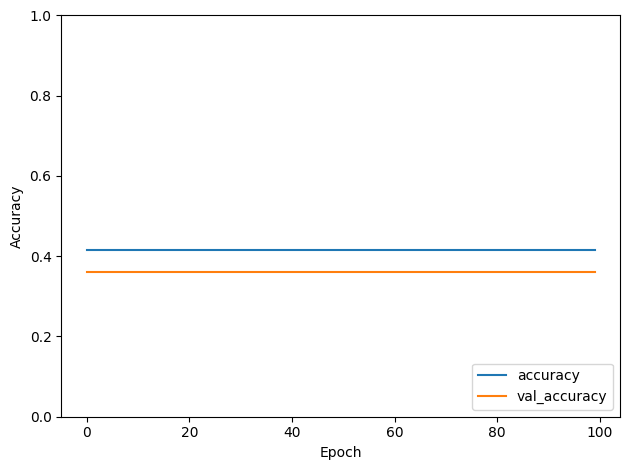

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Predicted vs Actual Plot

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


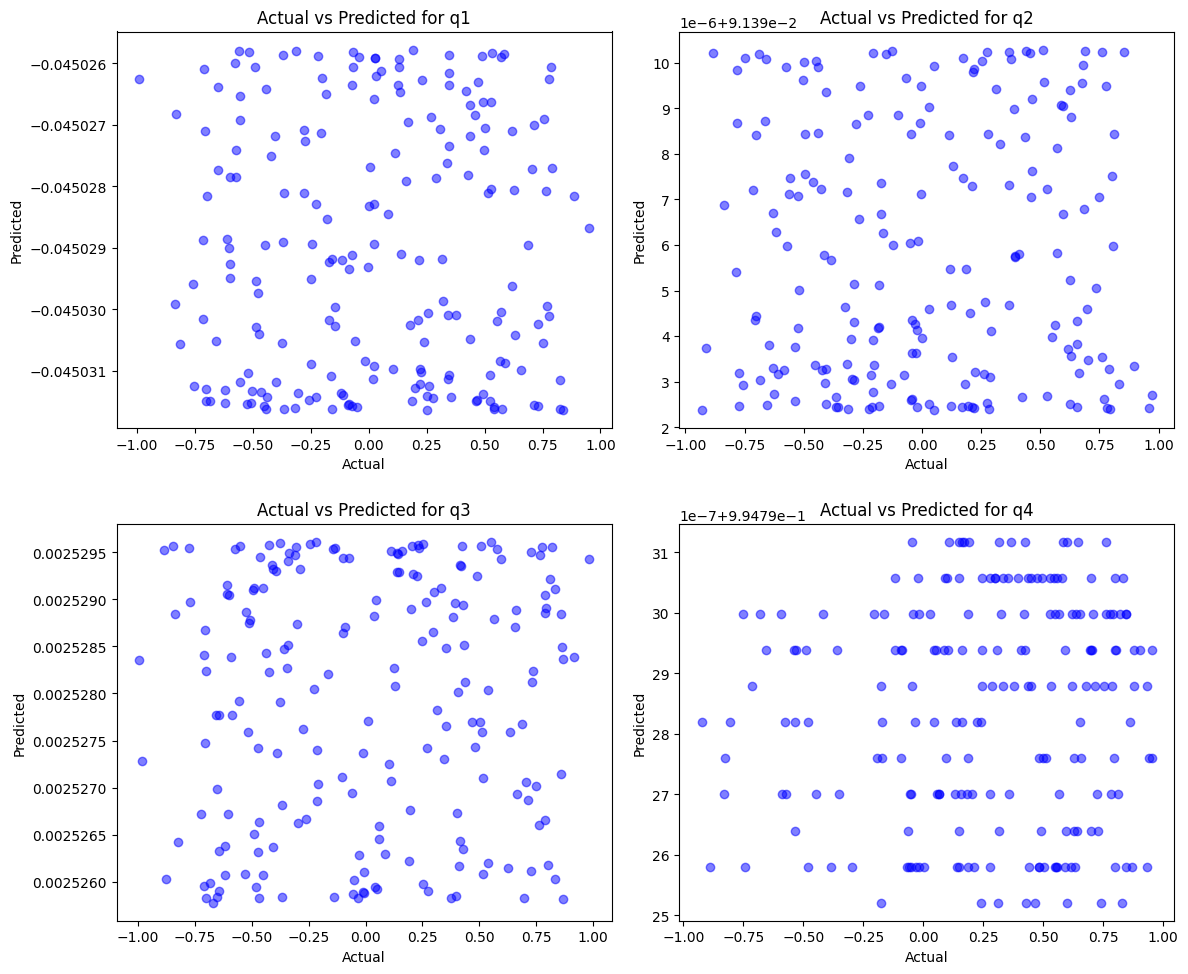

In [16]:
import matplotlib.pyplot as plt

# Predict on the validation data
y_pred = model.predict([X_val_img, X_val_num])

# Plot predicted vs actual for each component of rotation
components = ['q1', 'q2', 'q3', 'q4']  # Assuming the target is a quaternion

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i in range(4):
    axes[i].scatter(y_val[:, i], y_pred[:, i], color='blue', alpha=0.5)
    axes[i].set_title(f"Actual vs Predicted for {components[i]}")
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')

plt.tight_layout()
plt.show()


# Recurrent Neural Network (RNN)

## Model Architecture

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, LSTM, TimeDistributed
from tensorflow.keras.models import Model

# Number of past time steps to consider (sequence length)
sequence_length = 5  # You can adjust this to the number of previous steps

# CNN for image processing (this will be applied to each time step's image)
image_input = Input(shape=(sequence_length, 102, 102, 3))  # Now input is a sequence of images
cnn = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'))(image_input)
cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
cnn = TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu'))(cnn)
cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
cnn = TimeDistributed(Flatten())(cnn)

# Numerical input for each time step (e.g., date, satellite position)
numerical_input = Input(shape=(sequence_length, 1 + 3))  # 1 for timestamp + 3 for sat position

# Combine image and numerical inputs at each time step
combined = Concatenate()([cnn, numerical_input])

# Add an LSTM layer to capture temporal relationships
lstm_output = LSTM(128, return_sequences=False)(combined)  # 128 units, return only final state

# Fully connected layers after LSTM
y = Dense(128, activation='relu')(lstm_output)
y = Dense(64, activation='relu')(y)

# Output layer for satellite rotation prediction (4 values for quaternion)
output = Dense(4, activation='linear')(y)

# Normalize quaternion output to ensure it has unit length
quaternion_output = QuaternionNormalization()(output)

# Define model
model = Model(inputs=[image_input, numerical_input], outputs=quaternion_output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 5, 102,    │          0 │ -                 │
│ (InputLayer)        │ 102, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 5, 100,    │        896 │ input_layer_12[0… │
│ (TimeDistributed)   │ 100, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 5, 50, 50, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 5, 48, 48, │     18,496 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 5, 24, 24, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 5, 36864)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 5, 36868)  │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │ 18,942,464 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     16,512 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      8,256 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 4)         │        260 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quaternion_normali… │ (None, 4)         │          0 │ dense_20[0][0]    │
│ (QuaternionNormali… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,986,884 (72.43 MB)

 Trainable params: 18,986,884 (72.43 MB)

 Non-trainable params: 0 (0.00 B)

## Trainning the Model with Sequences

In [30]:
import numpy as np
import os
import random

# Load images and corresponding data
image_folder = './SyntheticImages'
images = []
numerical_data = []
targets = []
N = 200

# Get all filenames in the folder
all_filenames = os.listdir(image_folder)[:N]

for filename in selected_filenames:
  image_path = os.path.join(image_folder, filename)
  img = load_image(image_path)
  timestamp, sat_pos, sat_rot = extract_data_from_filename(filename)

  images.append(img)
  numerical_data.append(np.concatenate([[timestamp], sat_pos]))  # Concatenate timestamp and satellite position
  targets.append(sat_rot)  # Satellite rotation is the target, is a quaternion already normalized

images = np.array(images)
numerical_data = np.array(numerical_data)
targets = np.array(targets)

In [25]:
import numpy as np

# Example: preparing sequences for training
def create_sequences(images, numerical_data, targets, sequence_length):
  X_img_seq = []
  X_num_seq = []
  y_seq = []

  for i in range(sequence_length, len(images)):
    X_img_seq.append(images[i-sequence_length:i])  # Get the last `sequence_length` images
    X_num_seq.append(numerical_data[i-sequence_length:i])  # Get the corresponding satellite data
    y_seq.append(targets[i])  # Predict the quaternion at the current time step

  return np.array(X_img_seq), np.array(X_num_seq), np.array(y_seq)

# Create sequences from your data
X_img_seq, X_num_seq, y_seq = create_sequences(images, numerical_data, targets, sequence_length)

In [31]:
# Split data into training and validation sets (just like before)
from sklearn.model_selection import train_test_split
X_train_img, X_val_img, X_train_num, X_val_num, y_train, y_val = train_test_split(
  X_img_seq, X_num_seq, y_seq, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(
  [X_train_img, X_train_num], y_train,
  validation_data=([X_val_img, X_val_num], y_val),
  epochs=50,
  batch_size=32
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 891ms/step - accuracy: 0.3847 - loss: 0.3770 - val_accuracy: 0.4171 - val_loss: 0.3367
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 928ms/step - accuracy: 0.3834 - loss: 0.3666 - val_accuracy: 0.4171 - val_loss: 0.3370
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 899ms/step - accuracy: 0.3994 - loss: 0.3660 - val_accuracy: 0.4171 - val_loss: 0.3366
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 904ms/step - accuracy: 0.3814 - loss: 0.3778 - val_accuracy: 0.4171 - val_loss: 0.3367
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 932ms/step - accuracy: 0.3909 - loss: 0.3757 - val_accuracy: 0.4171 - val_loss: 0.3366
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 925ms/step - accuracy: 0.3939 - loss: 0.3802 - val_accuracy: 0.4171 - val_loss: 0.3366
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 886ms/step - accuracy: 0.4023 - loss: 0.3679 - val_accuracy: 0.4171 - val_loss: 0.3366
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 869ms/step - accuracy: 0.3944 - loss: 0.3813 - val_accu

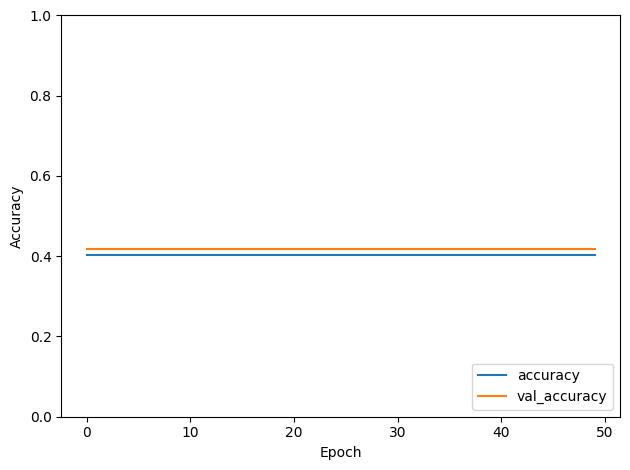

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


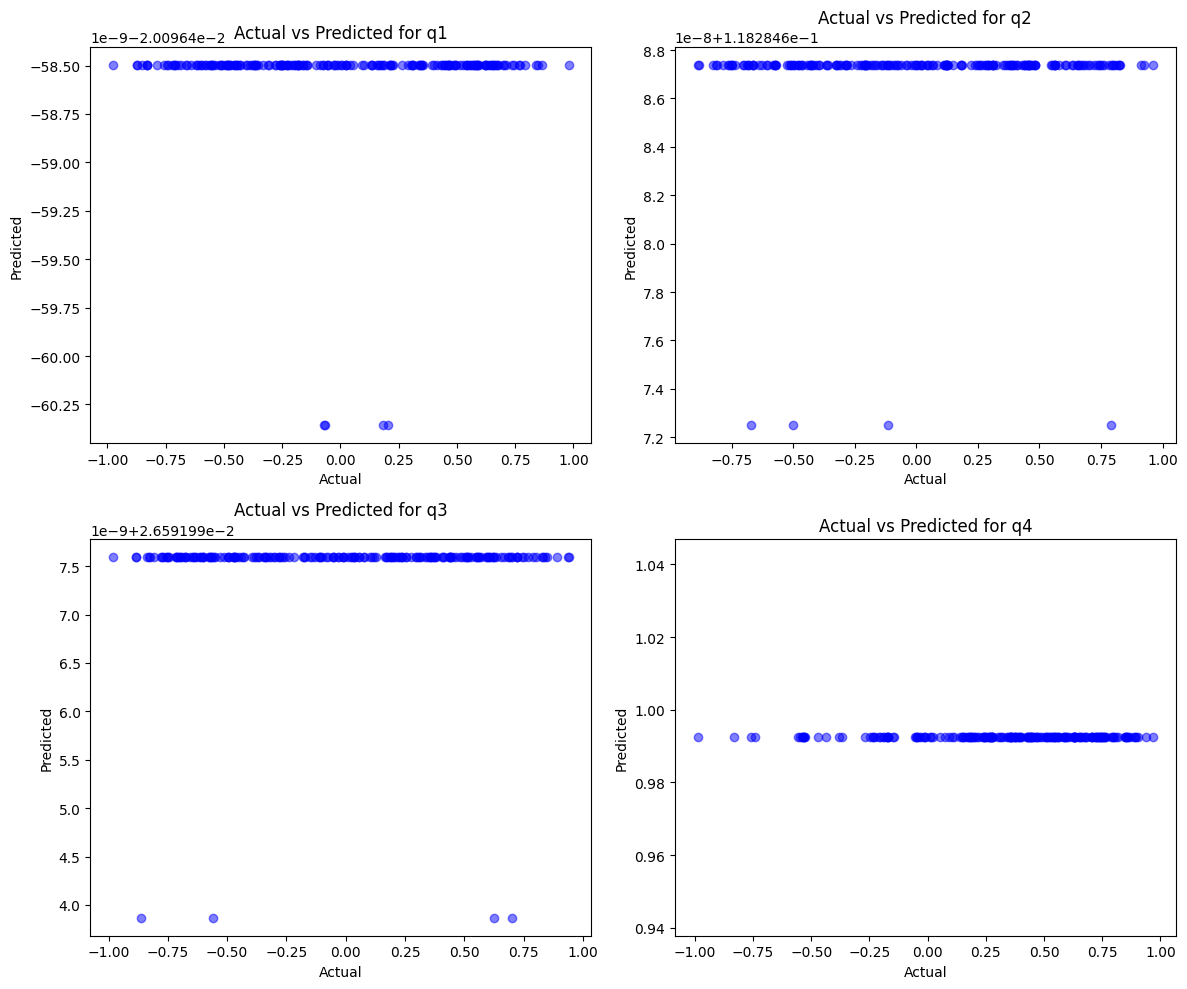

In [33]:
import matplotlib.pyplot as plt

# Predict on the validation data
y_pred = model.predict([X_val_img, X_val_num])

# Plot predicted vs actual for each component of rotation
components = ['q1', 'q2', 'q3', 'q4']  # Assuming the target is a quaternion

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i in range(4):
    axes[i].scatter(y_val[:, i], y_pred[:, i], color='blue', alpha=0.5)
    axes[i].set_title(f"Actual vs Predicted for {components[i]}")
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')

plt.tight_layout()
plt.show()